# Fama-French 3 Factor Model

Ryan Nie

# For Fiscal Year t = 2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

# Cleaning Up Imported Data

In [2]:
#Import data from WRDS and sort firm keys and fiscal year t
Bookval_df = pd.read_csv("BookValueData2.csv")
Bookval_df = Bookval_df.loc[:,:"txdb"]
Bookval_df.sort_values(["gvkey", "fyear"])

#shift fyear and gvkey to check if accounting data exist for 2 years prior
Bookval_df["gvkeylag1"] = Bookval_df["gvkey"].shift()
Bookval_df["fyearlag1"] = Bookval_df["fyear"].shift()

Bookval_df["gvkeylag2"] = Bookval_df["gvkey"].shift(2)
Bookval_df["fyearlag2"] = Bookval_df["fyear"].shift(2)

Bookval_df.head()

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,curcd,ceq,itcb,pstk,txdb,gvkeylag1,fyearlag1,gvkeylag2,fyearlag2
0,1004,05/31/2010,2009,INDL,C,D,STD,USD,746.906,0.0,0.0,57.335,NaN,NaN,NaN,NaN
1,1004,05/31/2011,2010,INDL,C,D,STD,USD,835.845,0.0,0.0,98.322,1004.0,2009.0,NaN,NaN
2,1004,05/31/2012,2011,INDL,C,D,STD,USD,864.649,0.0,0.0,115.908,1004.0,2010.0,1004.0,2009.0
3,1004,05/31/2013,2012,INDL,C,D,STD,USD,918.600,0.0,0.0,138.200,1004.0,2011.0,1004.0,2010.0
4,1004,05/31/2014,2013,INDL,C,D,STD,USD,999.500,0.0,0.0,162.200,1004.0,2012.0,1004.0,2011.0


In [3]:
#Check if accounting data exists for fyear t-1 and t-2

ValidYears_df = Bookval_df.loc[(Bookval_df["gvkey"] == Bookval_df["gvkeylag1"]) 
               & (Bookval_df["fyear"] == Bookval_df["fyearlag1"] +1)
              & (Bookval_df["gvkey"] == Bookval_df["gvkeylag2"])
              & (Bookval_df["fyear"] == Bookval_df["fyearlag2"] +2), ["gvkey", "fyear"]].reset_index(drop = True)

#These firms are valid with two proceeding years of accounting data from 2009 on
ValidYears_df

,gvkey,fyear
0,1004,2011
1,1004,2012
2,1004,2013
3,1004,2014
4,1004,2015
...,...,...
63848,345920,2020
63849,345980,2017
63850,345980,2018
63851,345980,2019


# Calculating Book Value For Fiscal Year 2020

In [4]:
#List of firms valid for year t = 2020 (Accounting data exists for t = 2018, 2019)
Firm_list2020 = ValidYears_df.loc[(ValidYears_df["fyear"] == 2020), "gvkey"].values 
Firm_list2020

array([  1045,   1050,   1075, ..., 339965, 345920, 345980])

In [5]:
#New data frame of all firms valid for year t = 2020, derived from data frame of all valid firms from 2009
Bookval2020_df = Bookval_df.loc[(Bookval_df["gvkey"].isin(Firm_list2020)) & (Bookval_df["fyear"]== 2020)].reset_index(drop = True)

#Change all NAN in txdb (Deferred Tax) to 0
Bookval2020_df["txdb"] = Bookval2020_df["txdb"].fillna(0)

#Calculate BE
Bookval2020_df["BE"] = Bookval2020_df.loc[:,"ceq"] + Bookval2020_df.loc[:,"txdb"] + Bookval2020_df.loc[:,"itcb"] - Bookval2020_df.loc[:,"pstk"]

#Drop all BE < 0 and NAN
Bookval2020_df = Bookval2020_df.loc[Bookval2020_df["BE"] > 0]
Bookval2020_df = Bookval2020_df.loc[~Bookval2020_df["BE"].isna()]
Bookval2020_df.head()

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,curcd,ceq,itcb,pstk,txdb,gvkeylag1,fyearlag1,gvkeylag2,fyearlag2,BE
1,1050,12/31/2020,2020,INDL,C,D,STD,USD,202.658,0.000,0.0,6.970,1050.0,2019.0,1050.0,2018.0,209.628
2,1075,12/31/2020,2020,INDL,C,D,STD,USD,5633.503,191.372,0.0,2135.403,1075.0,2019.0,1075.0,2018.0,7960.278
3,1076,12/31/2020,2020,INDL,C,D,STD,USD,986.136,0.000,0.0,126.938,1076.0,2019.0,1076.0,2018.0,1113.074
4,1078,12/31/2020,2020,INDL,C,D,STD,USD,32784.000,0.000,0.0,1406.000,1078.0,2019.0,1078.0,2018.0,34190.000
6,1104,12/31/2020,2020,INDL,C,D,STD,USD,62.716,0.000,0.0,0.110,1104.0,2019.0,1104.0,2018.0,62.826


# Calculating BE/ME for Fiscal Year 2020

In [6]:
#Merge BE and ME for Fiscal Year 2020 

#Import WRDS Data for Market Cap
ME_df = pd.read_csv("MarketCap.csv")

#Calculate Market Cap for FY 2020
ME_df["ME"] = ME_df["csho"]* ME_df["prcc_f"]

#Merge both data frames into one
MarketCap_df = pd.merge(Bookval2020_df.loc[:, ["gvkey", "fyear", "BE"]], 
                        ME_df.loc[:, ["gvkey", "fyear", "ME",]], 
                        left_on=["gvkey", "fyear"], 
                        right_on=["gvkey", "fyear"])

#Find BE/ME ratio
MarketCap_df.loc[:, "BE/ME"] = MarketCap_df.loc[:, "BE"] / MarketCap_df.loc[:, "ME"]

#This is the master data frame for fiscal year 2020 with all the qualifying firms and their respective BE/ME ratio
MarketCap_df

,gvkey,fyear,BE,ME,BE/ME
0,1050,2020,209.628,246.154320,0.851612
1,1075,2020,7960.278,9009.405600,0.883552
2,1076,2020,1113.074,3648.238010,0.305099
3,1078,2020,34190.000,193931.972700,0.176299
4,1104,2020,62.826,100.604070,0.624488
...,...,...,...,...,...
3725,331856,2020,158.785,323.658720,0.490594
3726,332115,2020,21.934,55.781811,0.393211
3727,339965,2020,4936.471,78443.259100,0.062930
3728,345920,2020,210.918,1761.430000,0.119742


# Creating the Six Portfolios

In [7]:
#Find the median Market Cap
median_ME = MarketCap_df["ME"].median()

#Rank BE/ME
MarketCap_df["ranked BE/ME"] = MarketCap_df["BE/ME"].rank(method='dense') #Ranked smallest to largest (1-3730)

MarketCap_df["ranked percentile"] = MarketCap_df["BE/ME"].rank(pct = True) #Ranked by percentile

#The data frame and number of firms ranked
print(MarketCap_df["ranked BE/ME"].max())
MarketCap_df.head()

3556.0


,gvkey,fyear,BE,ME,BE/ME,ranked BE/ME,ranked percentile
0,1050,2020,209.628,246.15432,0.851612,2842.0,0.799213
1,1075,2020,7960.278,9009.40560,0.883552,2878.0,0.809336
2,1076,2020,1113.074,3648.23801,0.305099,1548.0,0.435321
3,1078,2020,34190.000,193931.97270,0.176299,932.0,0.262092
4,1104,2020,62.826,100.60407,0.624488,2491.0,0.700506


In [8]:
#All firms sorted into Small vs Big, Growth vs Neutral vs Value

#Small firms with low BE/ME
SG_df = MarketCap_df.loc[(MarketCap_df["ME"] < median_ME) & (MarketCap_df["ranked percentile"] < 0.3)] 

#Small firms with neutral BE/ME
SN_df = MarketCap_df.loc[(MarketCap_df["ME"] < median_ME) 
                         & (MarketCap_df["ranked percentile"] >= 0.3) 
                         & (MarketCap_df["ranked percentile"] < 0.7)]

#Small firms with high BE/ME
SV_df = MarketCap_df.loc[(MarketCap_df["ME"] < median_ME) 
                         & (MarketCap_df["ranked percentile"] >= 0.7) 
                         & (MarketCap_df["ranked percentile"] <= 1)]

#Big firms with low BE/ME
BG_df = MarketCap_df.loc[(MarketCap_df["ME"] >= median_ME) & (MarketCap_df["ranked percentile"] < 0.3)]

#Big firms with neutral BE/ME
BN_df = MarketCap_df.loc[(MarketCap_df["ME"] >= median_ME) 
                         & (MarketCap_df["ranked percentile"] >= 0.3) 
                         & (MarketCap_df["ranked percentile"] < 0.7)]

#Big firms with high BE/ME
BV_df = MarketCap_df.loc[(MarketCap_df["ME"] >= median_ME) 
                         & (MarketCap_df["ranked percentile"] >= 0.7) 
                         & (MarketCap_df["ranked percentile"] <= 1)]

#Total firms, matches result from before
print(len(SN_df))

total_firms = len(SG_df) + len(SN_df) + len(SV_df) + len(BG_df) + len(BN_df) + len(BV_df)
print(total_firms)
SN_df

674
3556


,gvkey,fyear,BE,ME,BE/ME,ranked BE/ME,ranked percentile
5,1117,2020,22.524,37.911360,0.594123,2428.0,0.682790
33,1686,2020,501.055,961.703600,0.521008,2252.0,0.633296
72,2342,2020,23.843,48.552624,0.491075,2188.0,0.615298
74,2390,2020,73.584,165.637000,0.444249,2058.0,0.578740
77,2436,2020,208.491,573.666260,0.363436,1777.0,0.499719
...,...,...,...,...,...,...,...
3699,297510,2020,4.555,8.443440,0.539472,2312.0,0.650169
3709,315639,2020,37.360,108.747600,0.343548,1707.0,0.480034
3718,325867,2020,100.372,372.309540,0.269593,1398.0,0.393138
3725,331856,2020,158.785,323.658720,0.490594,2185.0,0.614454


In [9]:
#List of firms in each portfolio

SG = SG_df.loc[:, "gvkey"].values 
SN = SN_df.loc[:, "gvkey"].values 
SV = SV_df.loc[:, "gvkey"].values 

BG = BG_df.loc[:, "gvkey"].values 
BN = BN_df.loc[:, "gvkey"].values 
BV = BV_df.loc[:, "gvkey"].values 

#Total firms, results match from before
assert(len(SG) + len(SN) + len(SV) + len(BG) + len(BN) + len(BV) == total_firms)

# Import Monthly Stock Prices from December 2015 - December 2020

In [10]:
#Import and clean data from WRDS 
Returns_df = pd.read_csv("FF3MonthlyMarketCapReturns.csv", index_col = 2, parse_dates = True)
Returns_df["ME"] = Returns_df["prccm"] * Returns_df["cshom"]
Returns_df = Returns_df.loc[:, ["gvkey", "trt1m", "ME"]]

#Only want data with GVKEY from qualifying firms and set all NaN ME values to 0
Returns_df = Returns_df.loc[(Returns_df["gvkey"].isin(Firm_list2020))]
Returns_df["ME"] = Returns_df["ME"].fillna(0)

#This is the data frame with all qualifying firms and their monthly log returns from December 2015 - December 2020
Returns_df

,gvkey,trt1m,ME
datadate,,,
2015-12-31,1045,2.6418,2.669431e+10
2016-01-31,1045,-7.9339,2.457641e+10
2016-02-29,1045,5.4116,2.472374e+10
2016-03-31,1045,0.0244,2.472977e+10
2016-04-30,1045,-15.4109,2.005679e+10
...,...,...,...
2020-10-31,339965,-0.3904,1.010306e+10
2020-11-30,339965,30.3256,1.316687e+10
2020-12-31,339965,-13.6386,1.426698e+10


In [11]:
#Data frames of the performance for each portfolio

SGReturns_df = Returns_df.loc[(Returns_df["gvkey"].isin(SG))]
SNReturns_df = Returns_df.loc[(Returns_df["gvkey"].isin(SN))]
SVReturns_df = Returns_df.loc[(Returns_df["gvkey"].isin(SV))]
BGReturns_df = Returns_df.loc[(Returns_df["gvkey"].isin(BG))]
BNReturns_df = Returns_df.loc[(Returns_df["gvkey"].isin(BN))]
BVReturns_df = Returns_df.loc[(Returns_df["gvkey"].isin(BV))]

#Sample Data Frame
SNReturns_df

,gvkey,trt1m,ME
datadate,,,
2015-12-31,1117,-3.9024,54048920.0
2016-01-31,1117,0.0000,54048920.0
2016-02-29,1117,-2.2843,52814300.0
2016-03-31,1117,17.4026,62064120.0
2016-04-30,1117,10.1770,68380380.0
...,...,...,...
2020-08-31,332115,-12.9032,60487560.0
2020-09-30,332115,-1.5432,59554110.0
2020-10-31,332115,-2.1944,58247280.0


In [12]:
#Clean up each portfolio data by multi-indexing

SGReturns_df = SGReturns_df.reset_index().set_index(["gvkey", "datadate"])
SGReturns_df.sort_index(level=[0, 1], inplace=True)
SGReturns_df.loc[:,"trt1m"] = SGReturns_df.loc[:,"trt1m"]/100 #Percentages to decimal

SNReturns_df = SNReturns_df.reset_index().set_index(["gvkey", "datadate"])
SNReturns_df.sort_index(level=[0, 1], inplace=True)
SNReturns_df.loc[:,"trt1m"] = SNReturns_df.loc[:,"trt1m"]/100 #Percentages to decimal

SVReturns_df = SVReturns_df.reset_index().set_index(["gvkey", "datadate"])
SVReturns_df.sort_index(level=[0, 1], inplace=True)
SVReturns_df.loc[:,"trt1m"] = SVReturns_df.loc[:,"trt1m"]/100 ##Percentages to decimal

BGReturns_df = BGReturns_df.reset_index().set_index(["gvkey", "datadate"])
BGReturns_df.sort_index(level=[0, 1], inplace=True)
BGReturns_df.loc[:,"trt1m"] = BGReturns_df.loc[:,"trt1m"]/100 #Percentages to decimal

BNReturns_df = BNReturns_df.reset_index().set_index(["gvkey", "datadate"])
BNReturns_df.sort_index(level=[0, 1], inplace=True)
BNReturns_df.loc[:,"trt1m"] = BNReturns_df.loc[:,"trt1m"]/100 #Percentages to decimal

BVReturns_df = BVReturns_df.reset_index().set_index(["gvkey", "datadate"])
BVReturns_df.sort_index(level=[0, 1], inplace=True)
BVReturns_df.loc[:,"trt1m"] = BVReturns_df.loc[:,"trt1m"]/100 #Percentages to decimal

#Sample Data Frame
SNReturns_df

trt1m          ME
gvkey  datadate                        
1117   2015-12-31 -0.039024  54048920.0
       2016-01-31  0.000000  54048920.0
       2016-02-29 -0.022843  52814300.0
       2016-03-31  0.174026  62064120.0
       2016-04-30  0.101770  68380380.0
...                     ...         ...
332115 2020-08-31 -0.129032  60487560.0
       2020-09-30 -0.015432  59554110.0
       2020-10-31 -0.021944  58247280.0
       2020-11-30  0.016026  59285340.0
       2020-12-31 -0.058391  55823599.8

[36879 rows x 2 columns]

In [13]:
#Fill all Returns Data Frames' NaN values with 0
SGReturns_df["trt1m"] = SGReturns_df["trt1m"].fillna(0)
SNReturns_df["trt1m"] = SNReturns_df["trt1m"].fillna(0)
SVReturns_df["trt1m"] = SVReturns_df["trt1m"].fillna(0)

BGReturns_df["trt1m"] = BGReturns_df["trt1m"].fillna(0)
BNReturns_df["trt1m"] = BNReturns_df["trt1m"].fillna(0)
BVReturns_df["trt1m"] = BVReturns_df["trt1m"].fillna(0)

#Slicing, test
print(SNReturns_df.loc[(1117,"2015-12-31"), "trt1m"])
print(SNReturns_df.loc[(1117,"2015-12-31"), "ME"])

#Gives percentage change of a month
print("Firm 1117 had a monthly return of", SNReturns_df.loc[(1117, "2016-06-30"), "trt1m"][0], "in the month of 2015-06-30")

gvkey  datadate  
1117   2015-12-31   -0.039024
Name: trt1m, dtype: float64
gvkey  datadate  
1117   2015-12-31    54048920.0
Name: ME, dtype: float64
Firm 1117 had a monthly return of -0.066055 in the month of 2015-06-30


<ipython-input-14-9a12a4b8a56d>:4: RuntimeWarning: overflow encountered in exp
  plt.plot(np.cumprod(np.exp(SNReturns_df.loc[ID])))


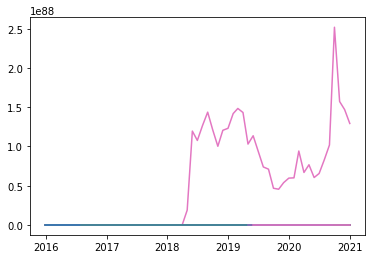

In [14]:
#Example equity curve with Small Neutral firms

for ID in SNReturns_df.index.unique("gvkey"):
    plt.plot(np.cumprod(np.exp(SNReturns_df.loc[ID]))) 
    
###Not so sure why it doesn't print the other time series, maybe too many at the same time?

<ipython-input-15-50a3399128de>:2: RuntimeWarning: overflow encountered in exp
  plt.plot(np.cumprod(np.exp(SNReturns_df.loc[1117])))
<ipython-input-15-50a3399128de>:3: RuntimeWarning: overflow encountered in exp
  plt.plot(np.cumprod(np.exp(SNReturns_df.loc[332115])))
<ipython-input-15-50a3399128de>:4: RuntimeWarning: overflow encountered in exp
  plt.plot(np.cumprod(np.exp(SNReturns_df.loc[1686])))


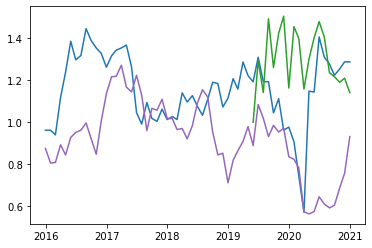

In [15]:
#This works, and NaNs do not matter
plt.plot(np.cumprod(np.exp(SNReturns_df.loc[1117])))
plt.plot(np.cumprod(np.exp(SNReturns_df.loc[332115])))
plt.plot(np.cumprod(np.exp(SNReturns_df.loc[1686])))

# Portfolio Time Series

In [16]:
#Want time series of the value weighted returns of all the stocks

#Do this for all 6 portfolios

#Small Neutral Portfolio Time Series
SN_TS = [] #Length should match all the dates
for date in SNReturns_df.index.unique("datadate"): 
    SN_ret = 0   #Every single return for every firm with that date will be appended here
    SNtotal_ME = 0
    for ID in SNReturns_df.index.unique("gvkey"):
        try:
            SN_ret += ((SNReturns_df.loc[(int(ID), str(date)), "ME"])[0] * 
                       (SNReturns_df.loc[(int(ID), str(date)), "trt1m"])[0])
            SNtotal_ME += (SNReturns_df.loc[(int(ID), str(date)), "ME"])[0]
        except:
            pass
    SN_TS.append(SN_ret/SNtotal_ME)

print(SNtotal_ME)

328823069111.60004


Text(0, 0.5, 'Growth of 1 USD')

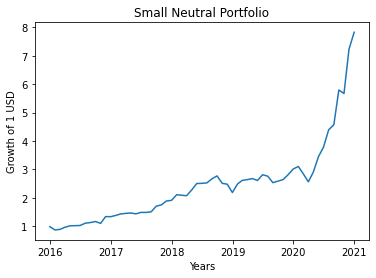

In [17]:
assert(len(SN_TS)==len(SNReturns_df.count(level="datadate"))) #No error, so algorithm works

#Performance of the Small Neutral portfolio
plt.plot(SNReturns_df.index.unique("datadate"), np.cumprod(np.exp(SN_TS)))
plt.title("Small Neutral Portfolio")
plt.xlabel("Years")
plt.ylabel("Growth of 1 USD")

In [18]:
#Small Value Portfolio Time Series
SV_TS = [] 
for date in SVReturns_df.index.unique("datadate"): 
    SV_ret = 0  
    SVtotal_ME = 0
    for ID in SVReturns_df.index.unique("gvkey"):
        try:
            SV_ret += ((SVReturns_df.loc[(int(ID), str(date)), "ME"])[0] * 
                       (SVReturns_df.loc[(int(ID), str(date)), "trt1m"])[0])
            SVtotal_ME += (SVReturns_df.loc[(int(ID), str(date)), "ME"])[0]
        except:
            pass
    SV_TS.append(SV_ret/SVtotal_ME)

In [19]:
#Small Growth Portfolio Time Series
SG_TS = [] 
for date in SGReturns_df.index.unique("datadate"): 
    SG_ret = 0  
    SGtotal_ME = 0
    for ID in SGReturns_df.index.unique("gvkey"):
        try:
            SG_ret += ((SGReturns_df.loc[(int(ID), str(date)), "ME"])[0] * 
                       (SGReturns_df.loc[(int(ID), str(date)), "trt1m"])[0])
            SGtotal_ME += (SGReturns_df.loc[(int(ID), str(date)), "ME"])[0]
        except:
            pass
    SG_TS.append(SG_ret/SGtotal_ME)

In [20]:
#Big Growth Portfolio Time Series
BG_TS = [] 
for date in BGReturns_df.index.unique("datadate"): 
    BG_ret = 0  
    BGtotal_ME = 0
    for ID in BGReturns_df.index.unique("gvkey"):
        try:
            BG_ret += ((BGReturns_df.loc[(int(ID), str(date)), "ME"])[0] * 
                       (BGReturns_df.loc[(int(ID), str(date)), "trt1m"])[0])
            BGtotal_ME += (BGReturns_df.loc[(int(ID), str(date)), "ME"])[0]
        except:
            pass
    BG_TS.append(BG_ret/BGtotal_ME)

In [21]:
#Big Neutral Portfolio Time Series
BN_TS = [] 
for date in BNReturns_df.index.unique("datadate"): 
    BN_ret = 0  
    BNtotal_ME = 0
    for ID in BNReturns_df.index.unique("gvkey"):
        try:
            BN_ret += ((BNReturns_df.loc[(int(ID), str(date)), "ME"])[0] * 
                       (BNReturns_df.loc[(int(ID), str(date)), "trt1m"])[0])
            BNtotal_ME += (BNReturns_df.loc[(int(ID), str(date)), "ME"])[0]
        except:
            pass
    BN_TS.append(BN_ret/BNtotal_ME)

In [22]:
#Big Value Portfolio Time Series
BV_TS = [] 
for date in BVReturns_df.index.unique("datadate"): 
    BV_ret = 0  
    BVtotal_ME = 0
    for ID in BVReturns_df.index.unique("gvkey"):
        try:
            BV_ret += ((BVReturns_df.loc[(int(ID), str(date)), "ME"])[0] * 
                       (BVReturns_df.loc[(int(ID), str(date)), "trt1m"])[0])
            BVtotal_ME += (BVReturns_df.loc[(int(ID), str(date)), "ME"])[0]
        except:
            pass
    BV_TS.append(BV_ret/BVtotal_ME)

# Debugging/Correcting Anomalies

12
1.622256805333742
39
32.82301018541599
2016-12-31 00:00:00
2019-03-31 00:00:00


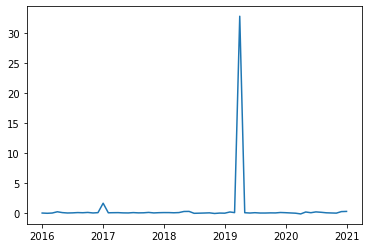

In [23]:
TS = [SG_TS, SN_TS, SV_TS, BG_TS, BN_TS, BV_TS]
dataframe = [SGReturns_df, SNReturns_df, SVReturns_df, BGReturns_df, BNReturns_df, BVReturns_df]
TS_name = ["SG_TS", "SN_TS", "SV_TS", "BG_TS", "BN_TS", "BV_TS"]

plt.plot(dataframe[0].index.unique("datadate"), TS[0], label = TS_name[0])

for i in range(len(SG_TS)):
    if SG_TS[i] > 1:
        print(i)
        print(SG_TS[i]) #Two anomalies in SG portfolio, faulty data points? i = 12, i = 39
        
print(dataframe[0].index.unique("datadate")[12]) # ~December 2016
print(dataframe[0].index.unique("datadate")[39]) # ~March 2019

In [24]:
#Finding anomaly in December 2016
for ID in SGReturns_df.index.unique("gvkey"):
    try:
        if SGReturns_df.loc[int(ID), "2016-12-31"]["trt1m"][0] > 2:
            print(SGReturns_df.loc[int(ID), "2016-12-31"])
    except:
        pass

#gvkey 177405 has a return of 1999

                  trt1m           ME
gvkey datadate                      
34382 2016-12-31  278.0  147328740.0
                      trt1m           ME
gvkey  datadate                         
143770 2016-12-31  2.378906  136121590.0
       2016-12-31  2.314286  182544560.0
                    trt1m          ME
gvkey  datadate                      
177405 2016-12-31  1999.0  25238000.0


In [25]:
SGReturns_df.loc[177405, "2016-12-31"]

,,trt1m,ME
gvkey,datadate,,
177405,2016-12-31,1999.0,25238000.0


In [26]:
#Finding anomaly in March 2019

for ID in SGReturns_df.index.unique("gvkey"):
    try:
        if SGReturns_df.loc[int(ID), "2019-03-31"]["trt1m"][0] > 2:
            print(SGReturns_df.loc[int(ID), "2019-03-31"])
    except:
        pass

#gvkey 283006 has a return of 1160

                     trt1m          ME
gvkey datadate                        
27809 2019-03-31  2.632236  10934400.0
                     trt1m           ME
gvkey datadate                         
33136 2019-03-31  57.18182  203512320.0
                    trt1m            ME
gvkey  datadate                        
283006 2019-03-31  1160.0  3.468499e+09


In [27]:
SGReturns_df.loc[283006, "2019-03-31"] #TICKER ITMR ipoed that month

,,trt1m,ME
gvkey,datadate,,
283006,2019-03-31,1160.0,3.468499e+09


In [28]:
#Correct anomaly by setting the return as the average return of the remaining stocks

#December 2016
old177405DecReturn = SGReturns_df.loc[177405, "2016-12-31"]["trt1m"][0]
SGReturns_df.loc[177405, "2016-12-31"]["trt1m"][0] = 0

dec2016 = []
for ID in SGReturns_df.index.unique("gvkey"):
    try:
        dec2016.append(SGReturns_df.loc[int(ID), "2016-12-31"]["trt1m"][0])   
    except:
        pass
    
SGReturns_df.loc[177405, "2016-12-31"]["trt1m"][0] = np.mean(dec2016)


#March 2019
old283006MarchReturn = SGReturns_df.loc[283006, "2019-03-31"]["trt1m"][0]
SGReturns_df.loc[283006, "2019-03-31"]["trt1m"][0] = 0

march2019 = []
for ID in SGReturns_df.index.unique("gvkey"):
    try:
        march2019.append(SGReturns_df.loc[int(ID), "2019-03-31"]["trt1m"][0])   
    except:
        pass
    
SGReturns_df.loc[283006, "2019-03-31"]["trt1m"][0] = np.mean(march2019)

In [29]:
#Changing the returns, theoretically, the ME changes too but the change in ME is too minute to be significant
for index, date in [(12, "2016-12-31"), (39, "2019-03-31")]: 
    SG_retIndex = 0  
    for ID in SGReturns_df.index.unique("gvkey"):
        try:
            SG_retIndex += ((SGReturns_df.loc[(int(ID), str(date)), "ME"])[0] * 
                       (SGReturns_df.loc[(int(ID), str(date)), "trt1m"])[0])
        except:
            pass
    SG_TS[index] = SG_retIndex/SGtotal_ME #call SGtotal_ME from before

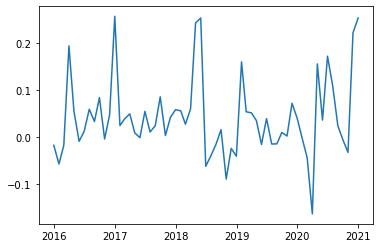

In [30]:
plt.plot(SGReturns_df.index.unique("datadate"), SG_TS, label = "SG_TS") #Portfolio looks a lot more reasonable 

# SMB and HML Time Series

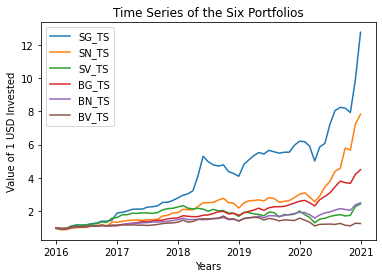

In [31]:
#Performance of all six portfolios

TS = [SG_TS, SN_TS, SV_TS, BG_TS, BN_TS, BV_TS]
dataframe = [SGReturns_df, SNReturns_df, SVReturns_df, BGReturns_df, BNReturns_df, BVReturns_df]
TS_name = ["SG_TS", "SN_TS", "SV_TS", "BG_TS", "BN_TS", "BV_TS"]


for i in range(len(TS)):
    plt.plot(dataframe[i].index.unique("datadate"), np.cumprod(np.exp(TS[i])), label = TS_name[i])
    
plt.title("Time Series of the Six Portfolios")
plt.xlabel("Years")
plt.ylabel("Value of 1 USD Invested")
plt.legend()
plt.show()

#Big growth firms outperform, which makes sense due to huge tech rallies in 2020
#Next up are neutrals
#Value stocks lag, makes sense because they usually have low volatility and high dividend rates

In [41]:
SG_TS = np.array(SG_TS)
SN_TS = np.array(SN_TS)
SV_TS = np.array(SV_TS)
BG_TS = np.array(BG_TS)
BN_TS = np.array(BN_TS)
BV_TS = np.array(BV_TS)

#SMB Time series
SMB = ((SV_TS + SN_TS + SG_TS) - (BV_TS + BN_TS + BG_TS))/3

#HML Time series
HML = ((SV_TS + BV_TS) - (SG_TS + BG_TS))/2 

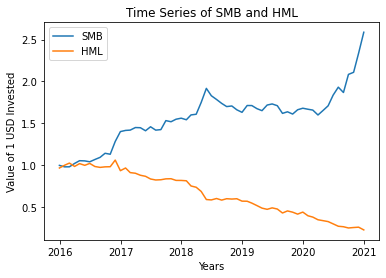

In [42]:
#Performance of SMB and HML
factors = [SMB, HML]
factor_name = ["SMB", "HML"]

for i in range(len(factors)):
    #Use any return dataframe for data date
    plt.plot(SNReturns_df.index.unique("datadate"), np.cumprod(np.exp(factors[i])), label = factor_name[i])
    
plt.title("Time Series of SMB and HML")
plt.xlabel("Years")
plt.ylabel("Value of 1 USD Invested")
plt.legend()
plt.show()